# Authors:
- Guijas Bravo, Pedro
- Miguélez Millos, Ángel

# 1. Initial setup

First of all, we will mount or Google Drive account to access faster the dataset. Otherwise, it would take a lot to upload the whole dataset each time to the Colab session.

This step is only necessary if you execute the notebook in Colab and if you have the dataset saved in your Drive account. Please, skip it in any other case.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ZIP_PATH = '/content//drive/MyDrive/'
!unzip -q {ZIP_PATH}/faces_dataset_train.zip -d ./
!unzip -q {ZIP_PATH}/faces_dataset_test.zip -d ./

Also, we will downgrade the tensorflow version in order to fix a bug related to data augmentation since the last versions work very slow when using it.

In [ ]:
!pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.5/498.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 48.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

# 2. Load dataset

This step will load and prepare the dataset for training. **Set the path to the train and test dataset folders in the `PATH` and `PATH_TEST` variables.**

Some comments about the dataset:
- The dataset is split into train and test (validation) subsets.
- Each image is a 32x32x3 tensor (RGB).
- Images are normalized between [-1, 1] to facilitate the learning process of the networks.
- Each label consists in whether the person in the image is a male (0) or a female (1).
- In each batch iteration, 128 images are seen.

In [ ]:
# Dataset path
from os import listdir
import os.path

# Set the paths to our datasets
PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [ ]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Image shape:  (32, 32, 3)
Label:  0


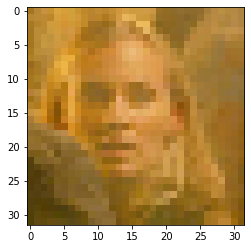

Image shape:  (32, 32, 3)
Label:  1


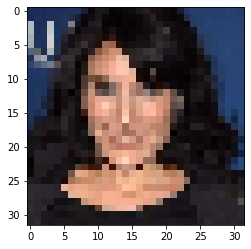

Image shape:  (32, 32, 3)
Label:  0


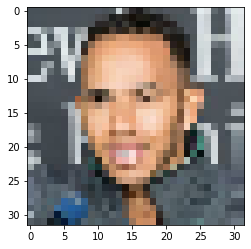

Image shape:  (32, 32, 3)
Label:  1


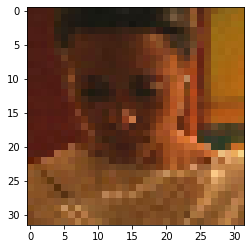

Image shape:  (32, 32, 3)
Label:  0


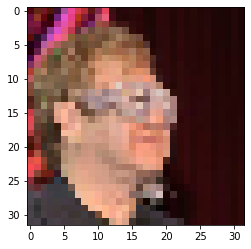

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(image.numpy())
    plt.show()

In [ ]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [ ]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [ ]:
# OPTIONAL: sample gender weights
"""
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))
"""

"\nimport numpy as np\nlabels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]\nfreqs = np.array([1. - np.mean(labels), np.mean(labels)])\ni_freqs = 1. / freqs\nsample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())\nprint(sample_weights)\nds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))\nds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))\n"

In [ ]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)  # validation test

# 3. Train and evaluate the model

In this section, we will define the training pipeline and perform experiments with some networks considered, saving checkpoints in the `CHECKPOINTS_FOLDER` folder. Please, change the path to an appropiate one of your system/account. Also, you can set later the `checkpoint` key of the hyperparameters to `None` in order to not save the model.

In [ ]:
CHECKPOINTS_FOLDER = "/content/drive/MyDrive/Checkpoints/"

## Define the pipeline

This subsection includes all the functions needed to create, train and show the results of the training of a network.

The network considered for this lab session is a typical **Convolutional Neural Network (CNN)**. This is because they are the most universal type of architectures used when working with images due to multiple factors:

- **Local connectivity**: the operation of the convolution with filters of a smaller size than the input means that the connectivity is local, which reduces the number of operations by performing computations only in subregions and not having connections to all the input, as in fully connected networks. In addition, it allows each neuron to specialize in a different feature, allowing complex interactions to be modeled as a function of the activations of different neurons.

- **Shared weights**: all neurons operating on the same feature map employ filters with the same coefficients (same kernel), further reducing the total number of parameters. Without this property, the filter coefficients at each point during the convolution process would vary. Intuitively, in the case of an image, it is understood that, for example, if a filter is useful for detecting edges at a certain position, it is also useful for detecting edges at any other position of the image.

- **Transalation invariance**: shared weights cause the data representations to be moved in the feature map when the input is also moved.

- **Spatial hierarchies of patterns**: the network learns how to represent the input information from the lowest level up through multiple layers to create increasingly sophisticated representations of the data. For example, the layers closest to the input are responsible for learning what an edge or a corner is, while later layers receive the information from these neurons and combine them to decide that if there are two vertical and horizontal edges in close proximity, parallel two by two, then you are dealing with a rectangle. This feature allows reusing networks that were trained on one dataset to apply them in other domains by changing only the deepest layers, which are specialized in the training domain.

- **No need for feature engineering**: filters are automatically learnt during the training process, so we do not need to hand-craft features in order to train efficiently the network. In fact, it is the same network the one that decides which features are most important by adapting its filters to the current problem.

As a typical CNN architecture, our networks consists in a sequence of convolution and max-pooling layers, ending with a classification block made of dense layers.

The convolutional layers are responsible for extracting the corresponding features from the image. Their depth is increased as we progress over the network since the complexity of the representations also increase so there are more possible combinations of patterns to capture.

The goal of the max-pooling layers are (1) to decrease the number of coefficients to be processed, especially important since we are increasing the number of feature maps sequentially, and (2) to induce spatial-filter hierarchies of the patterns being represented, so the receptive field (region of the original input image considered by a neuron) of following convolutional neurons is sequentially increased.

Our decision was to use **3 blocks of convolution and max-pooling, followed by the classification block**. Convolution layers have a depth of 32, 64 and 128, each of them followed by max-pooling layers (the depth is doubled while the resolutions is halved). At the end, the classification block consists in a dense layer of 1024 neurons and another dense layer with 1 neuron with a sigmoid activation, since we are looking for a binary output. These last layers are responsible for looking at the features extracted by the convolutional layers and classificate the input image accordingly. Notice that a flatten layer is needed between the convolutional blocks and the dense block because the latter only accepts a vector as input, not matrices or tensors.

From this basic design, we have also tested small variations to check whether some **regularization** would help to increase the performance of the network or not. For example, **batch normalization** layers can be added after the convolutional layers to make the training more stable, allowing a higher learning rate and increasing in turn the speed of the learning process. Batch normalization also mitigates the drawback of random weight initialization. **Dropout** can also be used on the 1024-neuron dense layer to eliminate the co-adaptation between them, making the network more robust to possible large individual weights of specific neurons that could dominate among the rest. **Data augmentation** can also be performed to increase the number of different samples seen by the network and make it more robust and independent of the training set.

In [ ]:
from tensorflow import keras
from keras import layers, regularizers

def create_model(use_bn=True, use_dropout=False, data_augmentation=None):

  # Depth is 3 because we are working with RGB images
  inputs = keras.Input(shape=(img_height, img_width, 3), name="input")

  if data_augmentation is not None:
    x = data_augmentation(inputs)

  # Feature extraction layers
  x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", name="conv1")(inputs if data_augmentation is None else x)

  if use_bn:
    x = layers.BatchNormalization(name="batch_norm1")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool1")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", name="conv2")(x)
    x = layers.BatchNormalization(name="batch_norm2")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool2")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", name="conv3")(x)
    x = layers.BatchNormalization(name="batch_norm3")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool3")(x)
  elif use_dropout:
    x = layers.Dropout(0.25, name="dropout1")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool1")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", name="conv2")(x)
    x = layers.Dropout(0.25, name="dropout2")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool2")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", name="conv3")(x)
    x = layers.Dropout(0.25, name="dropout3")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool3")(x)
    # x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", name="conv4")(x)
    # x = layers.Dropout(0.25, name="dropout4")(x)
    # x = layers.MaxPooling2D(pool_size=2, name="pool4")(x)
  else:
    x = layers.MaxPooling2D(pool_size=2, name="pool1")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", name="conv2")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool2")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", name="conv3")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool3")(x)
    # x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", name="conv4")(x)
    # x = layers.MaxPooling2D(pool_size=2, name="pool4")(x)

  # Classification layers
  x = layers.Flatten(name="flatten")(x)
  x = layers.Dense(1024, activation="relu", name="dense1")(x)

  if use_dropout:
    x = layers.Dropout(0.25, name="dropout_dense")(x)

  outputs = layers.Dense(1, activation="sigmoid", name="dense2")(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="cnn_genre")
  model.summary()

  return model

Apart from the already mentioned regularization techniques, we can also follow an **early stop** approach to avoid overfitting when the validation loss stops decreasing. This way, we can detect that the performance on the validation set is not improved while the training loss is still reduced, clearly indicator that the network is not able to generalize and is 'memorizing' the dataset (overfitting). If wanted, we can also use a **learning rate scheduler** to dynamically adapt the learning rate throughout the training. A model **checkpoint** is added to save the results periodically when we find a new configuration that beats the previous one.



In [ ]:
from keras import optimizer_v2

def train_model(model, ds_train_batch, ds_test_batch, epochs=20, lr=0.001, optimizer=optimizer_v2.adam.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
                loss="binary_crossentropy",
                metrics=["accuracy"])

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(ds_train_batch, epochs=epochs, validation_data=ds_test_batch, callbacks=callbacks)
  return history

We will show the evolution of the loss and the accuracy in the training and validation subsets.

In [ ]:
def plot_results(history):

  history = history.history
  loss, val_loss = history['loss'], history['val_loss']
  accuracy, val_accuracy = history['accuracy'], history['val_accuracy']

  epochs = range(1, len(loss) + 1)
  fig, axs = plt.subplots(1, 2, figsize=(9,4))

  for idx, measure in enumerate(["loss", "accuracy"]):
    axs[idx].plot(epochs, eval(measure), 'b-o', label=f'Training {measure}')
    axs[idx].plot(epochs, eval(f"val_{measure}"), 'r-o', label=f'Validation {measure}')
    axs[idx].set_title(f'Training and validation {measure}')
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel(measure.capitalize())
    axs[idx].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from keras import utils

def execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters, seed=1):

  # Set the seed to ensure reproducibility
  utils.tf_utils.set_random_seed(seed)

  model = create_model(use_bn=hyperparameters["bn"], use_dropout=hyperparameters["dropout"], data_augmentation=hyperparameters["augmentation"])
  history = train_model(model, ds_train_batch, ds_test_batch, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot_results(history)

  return model, history

## Test different configurations

This subsection contains the execution of some of the configurations tested. The discussion is reserved for the next section.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Example of hyperparameters
hyperparameters = {
    "epochs": 50,  # maximum number of epochs to train the network
    "lr": 0.001,  # initial learning rate of the optimizer
    "optimizer": optimizer_v2.adam.Adam,

    "bn": True,  # if True, perform batch normalization after the convolutional layers
    "dropout": False,  # if True, perform dropout

    # Set the following hyperparameters to None if you do not want to use them
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1),
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + 'checkpoint_name_{epoch}', 'val_loss', save_best_only=True)
}

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 128)         0 

992/992 [==============================] - 81s 71ms/step - loss: 0.3933 - accuracy: 0.8256 - val_loss: 0.3551 - val_accuracy: 0.8500
Epoch 2/25
991/992 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8747

992/992 [==============================] - 56s 56ms/step - loss: 0.3138 - accuracy: 0.8747 - val_loss: 0.3281 - val_accuracy: 0.8650
Epoch 3/25
992/992 [==============================] - 53s 53ms/step - loss: 0.2940 - accuracy: 0.8846 - val_loss: 0.3312 - val_accuracy: 0.8650
Epoch 4/25
991/992 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8892

992/992 [==============================] - 52s 52ms/step - loss: 0.2824 - accuracy: 0.8892 - val_loss: 0.3270 - val_accuracy: 0.8610
Epoch 5/25
991/992 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.8945

992/992 [==============================] - 53s 54ms/step - loss: 0.2719 - accuracy: 0.8945 - val_loss: 0.3210 - val_accuracy: 0.8750
Epoch 6/25
992/992 [==============================] - 52s 53ms/step - loss: 0.2613 - accuracy: 0.8988 - val_loss: 0.3413 - val_accuracy: 0.8640
Epoch 7/25
990/992 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.9009

992/992 [==============================] - 52s 53ms/step - loss: 0.2530 - accuracy: 0.9009 - val_loss: 0.3089 - val_accuracy: 0.8760
Epoch 8/25
992/992 [==============================] - 52s 52ms/step - loss: 0.2444 - accuracy: 0.9053 - val_loss: 0.3258 - val_accuracy: 0.8750
Epoch 9/25
992/992 [==============================] - 51s 52ms/step - loss: 0.2352 - accuracy: 0.9086 - val_loss: 0.3210 - val_accuracy: 0.8760
Epoch 10/25
992/992 [==============================] - 50s 50ms/step - loss: 0.2256 - accuracy: 0.9114 - val_loss: 0.3387 - val_accuracy: 0.8620
Epoch 11/25
992/992 [==============================] - 51s 52ms/step - loss: 0.2170 - accuracy: 0.9134 - val_loss: 0.3413 - val_accuracy: 0.8690
Epoch 12/25
992/992 [==============================] - 53s 54ms/step - loss: 0.2065 - accuracy: 0.9166 - val_loss: 0.3622 - val_accuracy: 0.8770


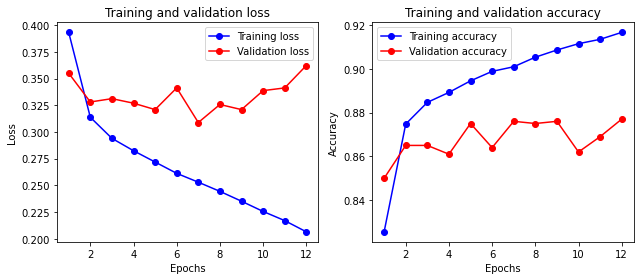

In [ ]:
# Baseline model
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": False,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_norm1 (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 batch_norm2 (BatchNormaliza  (None, 16, 16, 64)       256       
 tion)                                                   

992/992 [==============================] - 65s 64ms/step - loss: 0.4030 - accuracy: 0.8314 - val_loss: 0.3531 - val_accuracy: 0.8510
Epoch 2/25
992/992 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8800

992/992 [==============================] - 56s 57ms/step - loss: 0.3039 - accuracy: 0.8800 - val_loss: 0.3250 - val_accuracy: 0.8660
Epoch 3/25
992/992 [==============================] - 51s 51ms/step - loss: 0.2810 - accuracy: 0.8904 - val_loss: 0.3545 - val_accuracy: 0.8560
Epoch 4/25
992/992 [==============================] - 52s 53ms/step - loss: 0.2662 - accuracy: 0.8975 - val_loss: 0.3392 - val_accuracy: 0.8660
Epoch 5/25
992/992 [==============================] - 52s 53ms/step - loss: 0.2493 - accuracy: 0.9037 - val_loss: 0.3704 - val_accuracy: 0.8630
Epoch 6/25
992/992 [==============================] - 52s 53ms/step - loss: 0.2336 - accuracy: 0.9088 - val_loss: 0.3473 - val_accuracy: 0.8640
Epoch 7/25
992/992 [==============================] - 54s 55ms/step - loss: 0.2180 - accuracy: 0.9133 - val_loss: 0.3804 - val_accuracy: 0.8520


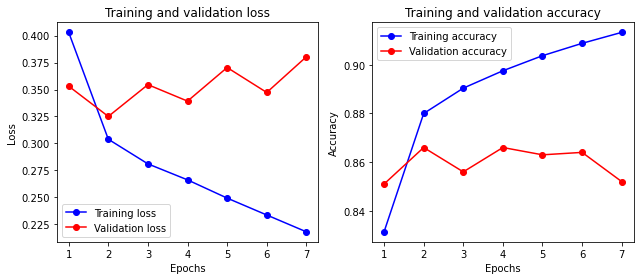

In [ ]:
# Batch normalized model
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_bn"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": True,
    "dropout": False,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_norm1 (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                         

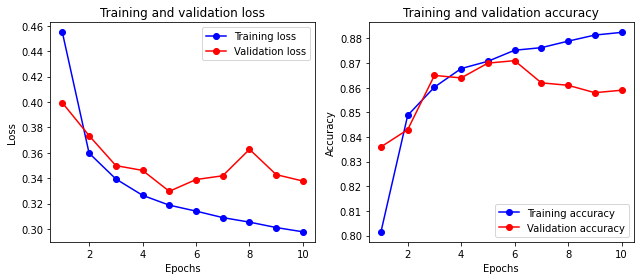

In [ ]:
# Batch normalized augmented model
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_bn_aug"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": True,
    "dropout": False,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0 

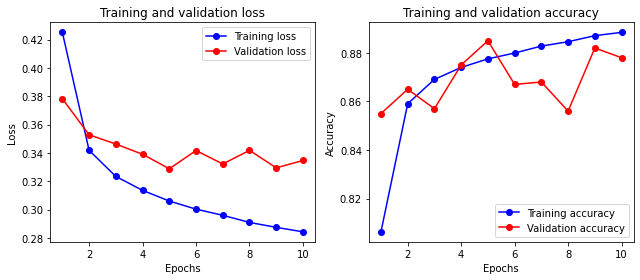

In [ ]:
# Dropout model
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_dropout"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

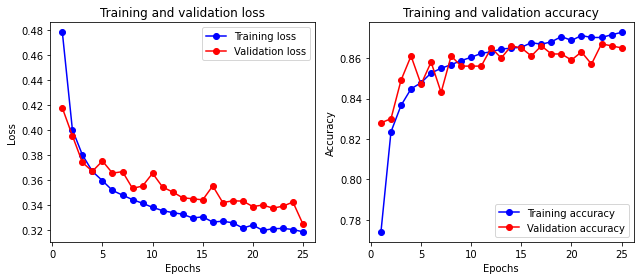

In [ ]:
# Dropout augmented model
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_dropout_aug"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

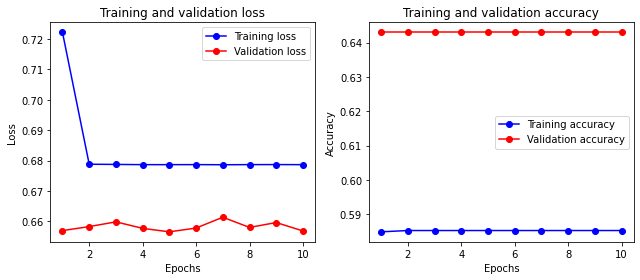

In [ ]:
# Dropout augmented model, with higher learning rate
checkpoint_filename = "cnn_genre_lr0.01_epoch{epoch}_dropout_aug"
hyperparameters = {
    "epochs": 25,
    "lr": 0.01,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

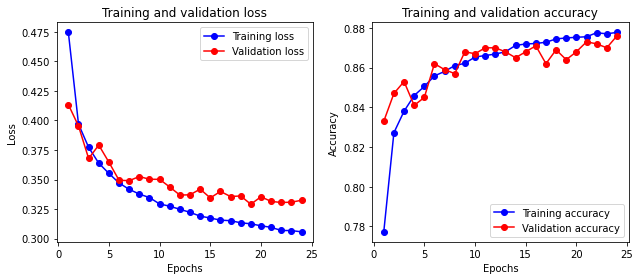

In [ ]:
# Dropout augmented model with lower learning rate
checkpoint_filename = "cnn_genre_lr0.0005_epoch{epoch}_dropout_aug"
hyperparameters = {
    "epochs": 50,
    "lr": 0.0005,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

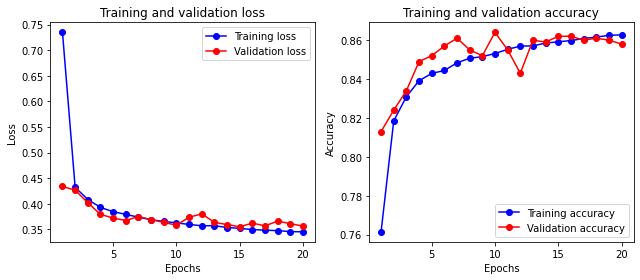

In [ ]:
# Dropout augmented model l2 (change create_model())
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_dropout_aug_l2(dense)"
hyperparameters = {
    "epochs": 40,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

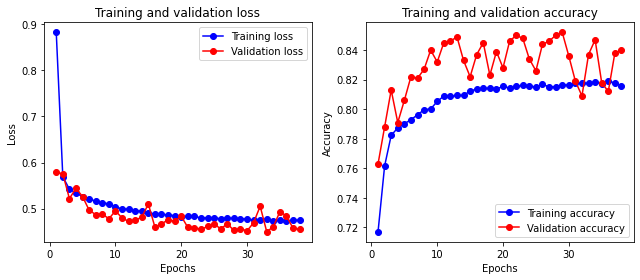

In [ ]:
# Dropout augmented model l2 in all layers (change create_model())
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_dropout_aug_l2(dense,cnn)"
hyperparameters = {
    "epochs": 40,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

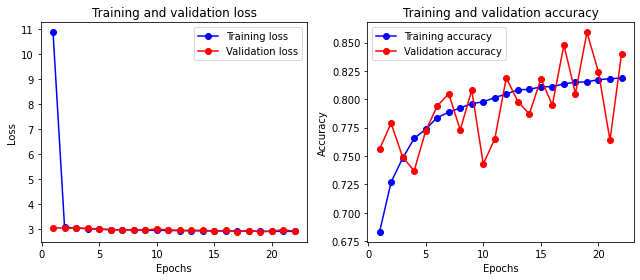

In [ ]:
# Dropout augmented model l1 (change create_model())
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_dropout_aug_l1(dense)"
hyperparameters = {
    "epochs": 40,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0 

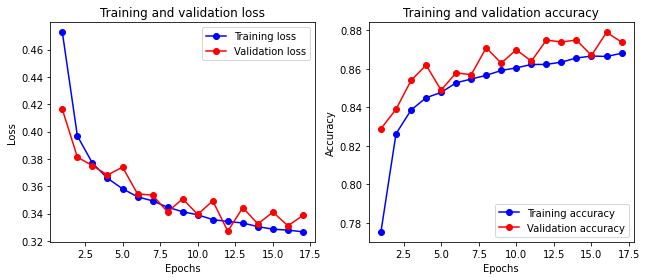

In [ ]:
# Dropout augmented model with 4 layers (change create_model())
checkpoint_filename = "cnn_genre_lr0.001_epoch{epoch}_dropout_aug_4conv"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_genre"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 64, 64, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 32, 32, 64)        0 

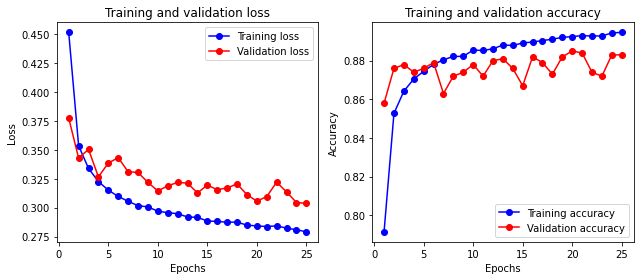

In [ ]:
# Dropout augmented model with 4 layers and 64x64 images (reload dataset and change create_model())
checkpoint_filename = "cnn_genre_64x64_lr0.001_epoch{epoch}_dropout_aug_4conv"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "bn": False,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": ModelCheckpoint(CHECKPOINTS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

## 4. Results

Multiple configurations have been tested. First of all, we have trained a baseline model as a starting point, having only the 3 blocks of convolution and max-pooling layers, plus the final classifier with denses layers. As expected, the model started to overfit very soon, in epoch 7, point from which the validation loss started to increase, while the training loss kept decreasing. However, the overall metrics were quite acceptable, with an accuracy of 90.09% in training and 87.60% in validation (a little big higher if we take the model from the very last epoch). Observing that the training loss and training accuracy was still improving, we tried to regularize the network in order to let the validation performance to be improved as well.

First of all, we have tried using batch normalization layers after the convolutional layers to make the training faster and more stable. However, although it improved the results in the training subset (it reached the 90% in less epochs), the model overfitted even sooner (since epoch 2). Therefore, we have seen that batch normalization helps to make the training faster, but in this case it did not avoid the overfitting.

Since batch normalization did not work out as expected, we have tried to also add some data augmentation to the dataset. In this case, we were able to complete 10 epochs, overfitting from epoch 6 instead of 2. The evolution of the training and validation curves was much smoother and synchronized. Even so, the potential improvement in training seemed to be restricted since the curve ended much flatter than in the previous cases. Specifically, while for the previous tests it could possible have reached a ~95% of accuracy, in this case it would hardly reach a ~91-92% of accuracy.

Having as a goal to reach the 90% in validation accuracy, we decided to repeat the previous process but replacing batch normalization with dropout layers to reduce possible co-adaptation of the neurons. First, without data augmentation, the results were a little bit better, reaching a validation accuracy of 88.50% (the best until now), starting to overfit after epoch 5. Also, the results between training and validation sets were more similar. While with batch normalization there was a difference of 6 percentual points in the last epoch, with dropout there is ~1 point. Second, with data augmentation, we have also observed a much smoother evolution of the curves, completing the full 25 epochs set for training. However, the final evolution was a little bit worse, with a maximum of 86.70% of accuracy in validation, that maybe could be improved a little bit setting more epochs. Again, the potential improvement in training seemed to be reduced, showing a flatter curve at the end of the training.

Instead of increasing the epochs, we tried to increase the learning rate (x10) but the results were disastrous since the model could not learn at all, getting stack at 58% and 64% of accuracy fro training and validation, respectively, since epoch 1. This was a clearly indicator that with such a high learning rate the model cannot converge, but jumps from one point to another again and again without reducing the loss. Then, since lower learning rates worked better, we tried to reduce the learning rate too (x0.5) it did not show significant changes with respect to the original learning rate.

We tried to apply some weight regularization too to check if some large weights could be dominating over other. First, using L2 regularization on the last dense layers, but it lead to similar results that without using it. Using L2 on both denses and convolutional layers, the model was able to train almost 40 epochs but with poorer results and with a lot of zig-zag in the validation accuracy. Using L1 instead, it went much worse, showing accuracies of lower than 80% and losses around 3.0.

Finally, we tried an architecture with a 4th block of convolution and pooling operations, with 256 filters, and 64x64 images to check if increasing the complexity and the amount of input information lead to better features and in turn to better results. The results did not improve the previous best 88.50% validation accuracy, and the overfitting was still there.

## 5. Conclusions

The main conclusion is that we can apply regularization techniques to extend the amount of time the network is learning, obtaining in turn similar training and validation curves (less overfitting). However, this did not lead to a significant improvement in the results that without regularization, were the model overfitted very soon. Also, weight regularization did not seem to be effective, since both L1 and L2 lead to worse results. Dropout is more effective than batch normalization in this case and data augmentation, although very slow, is the main regularization technique that is able to smooth the zig-zag in the validation curves at the expense of flattening the training curve (less potential improvement).

In general, we observe that the model is not able to achieve a 90% of accuracy in validation. In training it could be, without regularization and letting the network to be trained on for more epochs. With regularization, as mentioned before and especially with data augmentation, the training curve will hardly reach that value.

In [ ]:
%%shell
jupyter nbconvert --to html 'P1_CNN_Genre.ipynb'

[NbConvertApp] Converting notebook P1_CNN_Genre.ipynb to html
[NbConvertApp] Writing 1281383 bytes to P1_CNN_Genre.html
